<a href="https://colab.research.google.com/github/yiwenko/esm/blob/main/HTGAA_21_ESM_Variant_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/esm/blob/master/examples/variant_prediction.ipynb)

# Variant prediction with ESM

This tutorial demonstrates how to train a simple variant predictor, i.e. we predict the biological activity of mutations of a protein, using fixed embeddings from ESM. You can adopt a similar protocol to train a model for any downstream task, even with limited data.

We will use a simple classifier in sklearn (or "head" on top of the transformer features) to predict the mutation effect from precomputed ESM embeddings. The embeddings for your dataset can be dumped once using a GPU. Then, the rest of your analysis can be done on CPU. 

### Background

In this particular example, we will train a model to predict the activity of ß-lactamase variants.

We provide the training in `examples/P62593.fasta`, a FASTA file where each entry contains:
- the mutated ß-lactamase sequence, where a single residue is mutated (swapped with another amino acid)
- the target value in the last field of the header, describing the scaled effect of the mutation

The [data originally comes](https://github.com/FowlerLab/Envision2017/blob/master/data/dmsTraining_2017-02-20.csv) from a deep mutational scan and was released with the Envision paper (Gray, et al. 2018)

### Goals
- Obtain an embedding (fixed-dimensional vector representation) for each mutated sequence.
- Train a regression model in sklearn that can predict the "effect" score given the embedding.


### Prerequisites
- You will need the following modules : tqdm, matplotlib, numpy, pandas, seaborn, scipy, scikit-learn
- You have obtained sequence embeddings for ß-lactamase as described in the README, either by:
    - running `python extract.py esm1_t34_670M_UR50S examples/P62593.fasta examples/P62593_reprs/ --repr_layers 34 --include mean`  OR 
    - for your convenience we precomputed the embeddings and you can download them from [here](https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz) - see below to download this right here from in this notebook


### Table of Contents
1. [Prelims](#prelims)
1. [Loading Embeddings](#load_embeddings)
1. [Visualizing Embeddings](#viz_embeddings)
1. [Initializing / Running Grid Search](#grid_search)
1. [Browse Grid Search Results](#browse)
1. [Evaluating Results](#eval)

<a id='prelims'></a>
## Prelims

If you are using colab, run the cell below.
It will pip install the `esm` code, fetch the fasta file and the pre-computed embeddings.

In [1]:
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-oxyy936i
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-oxyy936i
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fair-esm: filename=fair_esm-0.4.2-py3-none-any.whl size=68336 sha256=994fc3f2be996d65b350d59bd38f94e7cf8e4437cb5b382493207b40eb81fc4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-08mq1rfb/wheels/5c/8e/11/307eca5379b418a9989ef4d24ead655755f2500a577ec95208
Successfully built fair-esm
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  8848k      0  0:00:02  0:00:02 --:--:-- 8845k
  % Total    % Received % Xferd  Average S

In [34]:
!git clone https://github.com/facebookresearch/esm

Cloning into 'esm'...
remote: Enumerating objects: 555, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 555 (delta 247), reused 206 (delta 183), pack-reused 245
Receiving objects: 100% (555/555), 9.58 MiB | 18.00 MiB/s, done.
Resolving deltas: 100% (327/327), done.


In [2]:
import torch
import esm

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


ProteinBertModel(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj):

tensor([ 0.1246,  0.0940, -0.0933,  ..., -0.0182,  0.0832, -0.0881])
tensor([ 0.1393,  0.1672, -0.2327,  ..., -0.0588,  0.0352, -0.1776])
tensor([ 0.1128,  0.0544, -0.2055,  ..., -0.0638,  0.0937, -0.1850])
tensor([ 0.1315,  0.1263, -0.2546,  ..., -0.0652,  0.0838, -0.2080])
tensor([ 0.1446,  0.0902, -0.2321,  ..., -0.0739,  0.0824, -0.1724])
tensor([ 0.1412, -0.1987, -0.0818,  ..., -0.1006, -0.0102, -0.0152])


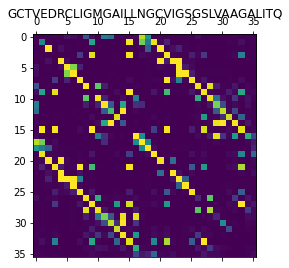

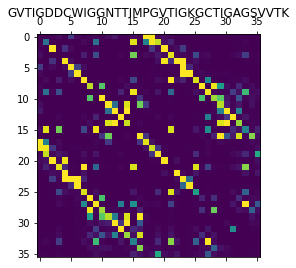

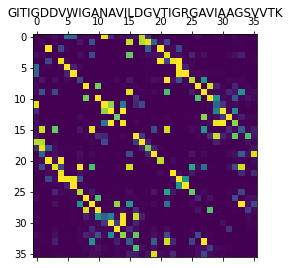

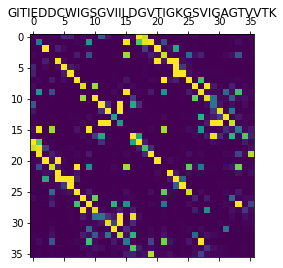

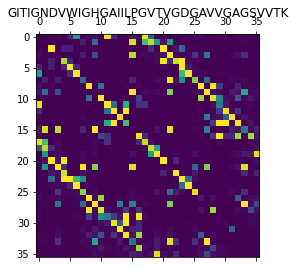

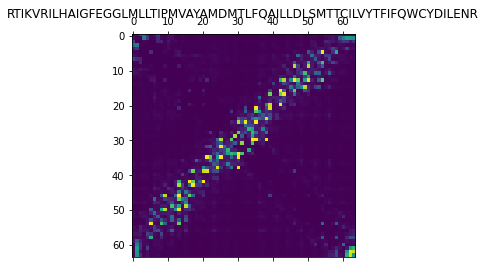

In [3]:
# Prepare data
data = [
    ("protein1", "GCTVEDRCLIGMGAILLNGCVIGSGSLVAAGALITQ"),
    ("protein2", "GVTIGDDCWIGGNTTIMPGVTIGKGCTIGAGSVVTK"),
    ("protein3", "GITIGDDVWIGANAVILDGVTIGRGAVIAAGSVVTK"),
    ("protein4", "GITIEDDCWIGSGVIILDGVTIGKGSVIGAGTVVTK"),
    ("protein5", "GITIGNDVWIGHGAIILPGVTVGDGAVVGAGSVVTK"),
    ("protein6", "RTIKVRILHAIGFEGGLMLLTIPMVAYAMDMTLFQAILLDLSMTTCILVYTFIFQWCYDILENR"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    print(token_representations[i, 1 : len(seq) + 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()

In [5]:
!pip install biopython==1.76
!pip3 install biopython==1.76

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 14.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import Bio.AlignIO
import Bio.Alphabet
import Bio.pairwise2
import Bio.Seq
import Bio.SeqIO

In [8]:
import os
import sys
BIOPYTHON_AVAILABLE=False
try:
  import Bio.AlignIO
  import Bio.Alphabet
  import Bio.pairwise2
  import Bio.Seq
  import Bio.SeqIO
  BIOPYTHON_AVAILABLE=True
except ImportError:
  msg = "Cannot import Biopython - some functionality will not be available." + os.linesep
  sys.stderr.write(msg)
class AlignmentParser(object):
    """ Parser for manipulation of MSAs """
    def a3mToTrimmed(self, alnFile, outFile):
        """Convert an .a3m HH-suite file to a FASTA format
        
        :alnFile: A3M format alignment file
        :outFile: MSA output file        """
        # A3m is similar to FASTA except indels and lower case letters
        records = list(Bio.SeqIO.parse(open(alnFile, 'r'), 'fasta'))
        records_formatted = self._a3mToTrimmed(records)
        
        Bio.SeqIO.write(records_formatted, open(outFile, 'w'), "fasta")
        return

    def _a3mToTrimmed(self, records):
        """Takes two file handlers"""
        for record in records:
            record.seq = Bio.Seq.Seq("".join([c for c in str(record.seq) if not c.islower()]),Bio.Alphabet.single_letter_alphabet)
        return records
    def align_sequences(self, seq1, seq2):
        """Global pairwise alignment of two sequences
        :returns: aligned sequences as tuple
        """
        alignment = Bio.pairwise2.align.globalms(seq1, seq2, 2, -1, -0.5, -0.1)
        return (alignment[-1][0], alignment[-1][1])
    def resetA3M(self, alnFile, outFile):
        """ Reset a A3M alignment to FASTA sequences
        
        Wrapper function for a3mToTrimmed() and removeGaps()
        
        :alnFile: A3M format alignment file
        :outFile: FASTA sequence file"""
        records = list(Bio.SeqIO.parse(open(alnFile, 'r'), 'fasta'))
        records_trimmed = self._a3mToTrimmed(records)
        records_trimmed_gapped = self._removeGaps(records)
        
        Bio.SeqIO.write(records_trimmed_gapped, open(outFile, 'w'), "fasta")
        return
    def read(self, alnFile, alnFormat):
        """Read a multiple sequence alignment
        
            :alnFile: MSA file
            :alnFormat: MSA format
        
            :returns: Biopython MSA generator"""
        return Bio.AlignIO.parse(open(alnFile, 'r'), alnFormat)
    def removeGaps(self, alnFile, outFile):
        """ Remove all gaps in a MSA
        
        :alnFile: FASTA alignment file
        :outFile: FASTA sequence file"""
        # Instead of reading an AlignIO object read as SeqIO object to treat them
        # straight away as individual sequences
        records = list(Bio.SeqIO.parse(open(alnFile, 'r'), 'fasta'))
        records_formatted = self._removeGaps(records)
        
        Bio.SeqIO.write(records_formatted, open(outFile, 'w'), "fasta")
        return

    def _removeGaps(self, records):
        """ Format the string to remove the gaps"""
        for record in records:  
            record.seq = Bio.Seq.Seq(str(record.seq).replace("-", ""), 
                                     Bio.Alphabet.single_letter_alphabet)
        return records
    def write(self, alignment, file, format):
        """Write a MSA object to a file"""
        Bio.AlignIO.write(alignment, open(file, 'w'), format)
        return

In [20]:
parser=AlignmentParser()
parser.a3mToTrimmed('test_4d625.a3m','test_4d625.fasta')
parser.removeGaps('test_4d625.fasta','test_4d625_1.fasta')

In [25]:
records = list(Bio.SeqIO.parse(open('test_4d625_1.fasta', 'r'), 'fasta'))
data=[]
for i,record in enumerate(records):
  data.append((i,record.seq))
batch_labels, batch_strs, batch_tokens = batch_converter(data)

/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:182: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  BiopythonWarning,


In [28]:
# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))



tensor([[ 0,  6, 23,  ..., 11, 16,  2],
        [ 0,  6,  7,  ..., 11, 15,  2],
        [ 0,  6, 12,  ..., 11, 15,  2],
        ...,
        [ 0, 12,  6,  ...,  1,  1,  1],
        [ 0, 11, 12,  ...,  2,  1,  1],
        [ 0, 12, 15,  ...,  1,  1,  1]])

In [40]:
!python esm/scripts/extract.py esm1b_t33_650M_UR50S esm/examples/data/some_proteins.fasta examples/data/some_proteins_emb_esm1b/ \
    --repr_layers 0 32 33 --include mean per_tok

tcmalloc: large alloc 2609438720 bytes == 0xa1a80000 @  0x7fe2eaf76b6b 0x7fe2eaf96379 0x7fe27b770d57 0x7fe27b75ebc3 0x7fe2cd513fa1 0x5946b8 0x548cc1 0x51566f 0x549e0e 0x4bcb19 0x59582d 0x595b69 0x62026d 0x55de15 0x59af67 0x515655 0x549e0e 0x4bca8a 0x5134a6 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x548ae9 0x5127f1 0x593dd7 0x5118f8 0x593dd7 0x5118f8
tcmalloc: large alloc 2609438720 bytes == 0x13d30e000 @  0x7fe2eaf76b6b 0x7fe2eaf96379 0x7fe27b770d57 0x7fe27b75ebc3 0x7fe2cd513fa1 0x5946b8 0x548cc1 0x51566f 0x549e0e 0x4bcb19 0x59582d 0x595b69 0x62026d 0x55de15 0x59af67 0x515655 0x549e0e 0x4bca8a 0x5134a6 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x548ae9 0x5127f1 0x593dd7 0x5118f8 0x593dd7 0x5118f8
^C


In [ ]:
!python esm/scripts/extract.py esm1b_t33_650M_UR50S 

In [9]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import esm

In [3]:
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor

## Add the path to your embeddings here:


In [ ]:
FASTA_PATH = "./P62593.fasta" # Path to P62593.fasta
EMB_PATH = "./P62593_reprs/" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

<a id='load_embeddings'></a>
## Load embeddings (Xs) and target effects (ys)
Our FASTA file is formatted as such:
```
>{index}|{mutation_id}|{effect}
{seq}
```
We will be extracting the effect from each entry.

Our embeddings are stored with the file name from fasta header: `{index}|{mutation_id}|{effect}.pt`

In [ ]:
ys = []
Xs = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header[1:]}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

### Train / Test Split

Here we choose to follow the Envision paper, using 80% of the data for training, but we actually found that pre-trained ESM embeddings require fewer downstream training examples to reach the same level of performance.

In [ ]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

In [ ]:
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

### PCA

Principal Component Analysis is a popular technique for dimensionality reduction. Given `n_features` (1280 in our case), PCA computes a new set of `X` that "best explain the data." We've found that this enables downstream models to be trained faster with minimal loss in performance.  

Feel free to change it!!


In [ ]:
pca = PCA(48)
Xs_train_pca = pca.fit_transform(Xs_train)

print(Xs_train_pca.shape)

<a id='viz_embeddings'></a>
## Visualize Embeddings

Here, we plot the first two principal components on the x- and y- axes. Each point is then colored by its scaled effect (what we want to predict).

Visually, we can see a separation based on color/effect, suggesting that our representations are useful for this task, without any task-specific training!

In [ ]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

<a id='grid_search'></a>

## Initialize / Run GridSearch

We will run grid search for three different regression models:
1. [K-nearest-neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
2. [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR)
3. [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforestregressor#sklearn.ensemble.RandomForestRegressor)

Here, we will be using the PCA-projected features because we observe it does just as well as `Xs` while allowing for faster training. You can easily swap it out for `Xs`.

### Initialize grids for different regression techniques

In [ ]:
knn_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15, 30],
    'p' : [1, 2],
}

svm_grid = {
    'C' : [0.1, 1.0, 10.0],
    'kernel' :['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3],
    'gamma': ['scale'],
}

rfr_grid = {
    'n_estimators' : [20],
    'criterion' : ['mse', 'mae'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [5, 10],
    'min_samples_leaf': [1, 4]
}

**Here you choose which regressor you want to evaluate, uncomment the one you want and continue**

In [ ]:
#regressor = KNeighborsRegressor
#param_grid = knn_grid

# regressor = SVR
# param_grid = svm_grid

# regressor = RandomForestRegressor
# param_grid = rfr_grid

### Run Grid Search 

(will take a few minutes on a single core)

In [ ]:
print(regressor)
grid = GridSearchCV(
    estimator = regressor(), 
    param_grid = param_grid,
    scoring = 'r2',
    verbose = 1,
    n_jobs = -1 # use all available cores
)
grid.fit(Xs_train_pca, ys_train)
result = pd.DataFrame.from_dict(grid.cv_results_)

<a id='eval'></a>
## Evaluation

Now that we have run grid search, each `grid` object contains a `best_estimator_`.

We can use this to evaluate the correlation between our predictions and the true effect scores on the held-out validation set.

In [ ]:
Xs_test_pca = pca.transform(Xs_test)

print(grid.best_estimator_)
print()
preds = grid.predict(Xs_test_pca)
print(f'{scipy.stats.spearmanr(ys_test, preds)}')
print('\n', '-' * 80, '\n')


Report which <a href="https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient">Spearman rho</a> you got. 